# ExprRules.jl

This is the base package to support the generation and optimization of Julia expressions from a grammar.  The package contains many basic functions for declaring and working with grammars and expression trees.

## Installation

    Pkg.add("ExprRules")

Once it's installed, start using the package by calling:

In [1]:
using ExprRules

## Usage

### Define a grammar

Grammars are specified by production rules that specify substitutions of non-terminal symbols.  Each production rule is an equality with a non-terminal on the left side and a Julia expression on the right side.  

The _() syntax is a special function where the argument is evaluated at the time of derivation tree's construction and the value is held constant throughout the life of the tree.  The pipe (|) syntax is a short-hand that allows the user to define multiple production rules on a single line (i.e., Backus-Naur Form).  The |() syntax is another similar short-hand that takes a collection as argument and creates a production rule for each element in the collection.

In [2]:
grammar = @grammar begin
    Real = x                      # symbol
    Real = Real * Real            # julia expression
    Real = f(Real)                # function call
    Real = _(Base.rand(1.0:5.0))  # special syntax, eval argument of _() at derivation time
    Real = A | B | cos(Real)        # multiple rules on a single line
    Real = 1 | 2 | 3
    Real = |(4:6)                 # same as Real = 4 | 5 | 6
    Real = |([7,8,9])             # same as Real = 7 | 8 | 9 
end

1: Real = x
2: Real = Real * Real
3: Real = f(Real)
4: Real = _(Base.rand(1.0:5.0))
5: Real = A
6: Real = B
7: Real = cos(Real)
8: Real = 1
9: Real = 2
10: Real = 3
11: Real = 4
12: Real = 5
13: Real = 6
14: Real = 7
15: Real = 8
16: Real = 9


In [3]:
f(x) = 2x

f (generic function with 1 method)

## Grammar helper functions

List non-terminals of the grammar:

In [4]:
nonterminals(grammar)

1-element Array{Symbol,1}:
 :Real

Grammars are indexed by non-terminal symbols and return the corresponding production rule numbers with that nonterminal.

In [5]:
grammar[:Real]

16-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16

Get the return type of the first production rule:

In [6]:
return_type(grammar, 1)

:Real

Get the number of children of the second production rule:

In [7]:
nchildren(grammar, 2)

2

Get the child types of the second production rule:

In [8]:
child_types(grammar, 2)

2-element Array{Symbol,1}:
 :Real
 :Real

Get the maximum number of children (arity) of the grammar:

In [9]:
max_arity(grammar)

2

Determine if the third production rule is terminal:

In [10]:
isterminal(grammar, 3)

false

Determine if the fourth production rule is a special _() function:

In [11]:
iseval(grammar, 4)

true

## Expression trees

An expression tree represents the derivation of an expression as a tree.  The nodes in an expression tree contain an index to a production rule.

Define an expression tree manually:

In [12]:
rulenode = RuleNode(3, [RuleNode(6)])
display(rulenode, grammar)

Generate a random expression tree from the grammar:

In [13]:
using Random

In [14]:
Random.seed!(138)
rulenode = rand(RuleNode, grammar, :Real, 10)
display(rulenode, grammar)

Evaluate the expression defined by the expression tree:

In [15]:
x=0.5
Core.eval(rulenode, grammar)

0.8775825618903728

Get the executable Julia expression from an expression tree:

In [16]:
ex = get_executable(rulenode, grammar)

:(cos(x))

Rather than using Julia's built-in eval function, a much more performant way of evaluating an expression is to use ExprRule's interpreter by providing a custom symbol table.  SymbolTable can try to automatically populate the symbol table by analyzing the grammar.  Symbols corresponding to input variables should be provided at on-the-fly.  Benchmarking suggests that using the custom interpreter can yield up to 20x performance improvement.

In [17]:
S = SymbolTable(grammar)
S[:x] = 5
Core.eval(S, ex)

0.28366218546322625

Sample a random node in the tree:

In [18]:
Random.seed!(0)
sample(rulenode)

7{1}

Sample a random node of type :Real in the expression tree:

In [19]:
Random.seed!(3)
sample(rulenode, :Real, grammar)

7{1}

Sample a random node in the tree and store the location in a NodeLoc object:

In [20]:
Random.seed!(1)
loc = sample(NodeLoc, rulenode)

NodeLoc(7{1}, 1)

Retrieve the node pointed to by the NodeLoc object:

In [21]:
get(rulenode, loc)

1,

Replace the subtree pointed to by loc with a randomly generated subtree:

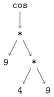

In [22]:
Random.seed!(28)
insert!(rulenode, loc, rand(RuleNode, grammar, :Real, 3))
display(rulenode, grammar)

## Minimum Depth Map

Compute the minimum depth of all possible subtrees for each production rule:

In [23]:
dmap = mindepth_map(grammar)

16-element Array{Int64,1}:
 0
 1
 1
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0

Compute the minimum depth of all possible subtrees starting from a given start symbol:

In [24]:
mindepth(grammar, :Real, dmap) #zero for terminals

0

## Expression Iterator

Iterate over all possible expressions of a grammar up to depth 2:

In [25]:
grammar = @grammar begin
    Real = Real + Real
    Real = 1 | 2
end
iter = ExpressionIterator(grammar, 2, :Real)
collect(iter)

6-element Array{RuleNode,1}:
 1{2,2}
 1{2,3}
 1{3,2}
 1{3,3}
 2,    
 3,    

Count the number of expressions of a grammar up to depth 2:

In [26]:
count_expressions(grammar, 2, :Real)

6

## AbstractTrees.jl Interface

In [27]:
using AbstractTrees

Print RuleNode tree in textual format.  Leaf nodes are the rule numbers in the grammar.

In [28]:
tree = RuleNode(1, [RuleNode(2), RuleNode(1, [RuleNode(2), RuleNode(3)])])
print_tree(tree)

1
├─ 2
└─ 1
   ├─ 2
   └─ 3
